The tutorial that led me to this project is https://www.tensorflow.org/tutorials/generative/style_transfer

In [ ]:
import tensorflow as tf

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
with tf.device('/CPU:0'):
  a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
  b = tf.constant([[1.0, 2.0], [3.0, 4.0], [5.0, 6.0]])

c = tf.matmul(a, b)
print(c)

tf.Tensor(
[[22. 28.]
 [49. 64.]], shape=(2, 2), dtype=float32)


In [ ]:
import os

os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [ ]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [ ]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor) > 3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [ ]:
content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')
style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

83281/83281 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
195196/195196 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
#Define a function to load an image and limit its maximum dimension to 512 pixels.

def load_image(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [ ]:
def show_image(image, title=None):
  if (len(image.shape) > 3):
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

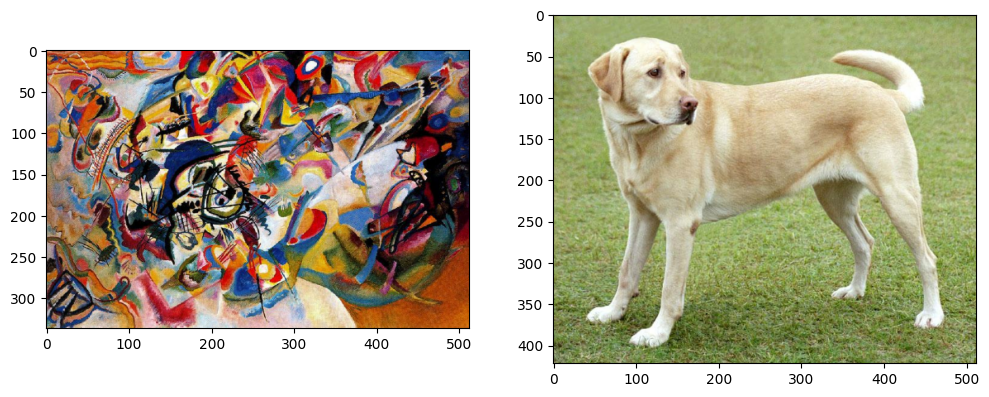

In [ ]:
tf.keras.backend.clear_session()
tf.debugging.set_log_device_placement(False)

content_image = load_image(content_path)
style_image = load_image(style_path)

plt.subplot(1, 2, 1)
show_image(style_image)

plt.subplot(1, 2, 2)
show_image(content_image)

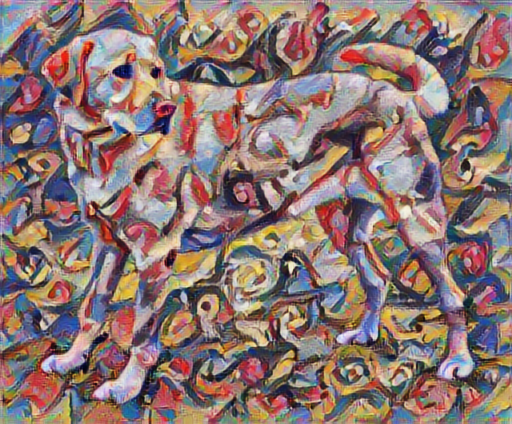

In [ ]:
import tensorflow_hub as hub

hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

Define content and style representations
Use the intermediate layers of the model to get the content and style representations of the image. Starting from the network's input layer, the first few layer activations represent low-level features like edges and textures. As you step through the network, the final few layers represent higher-level features—object parts like wheels or eyes. In this case, you are using the VGG19 network architecture, a pretrained image classification network. These intermediate layers are necessary to define the representation of content and style from the images. For an input image, try to match the corresponding style and content target representations at these intermediate layers.

In [ ]:
x = tf.keras.applications.vgg19.preprocess_input(content_image * 255)
x = tf.image.resize(x, (224, 224))
vgg = tf.keras.applications.vgg19.VGG19(include_top = True, weights='imagenet')
prediction_probabilities = vgg(x)
prediction_probabilities.shape

574710816/574710816 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


TensorShape([1, 1000])

In [ ]:
predicted_top_five = tf.keras.applications.vgg19.decode_predictions(prediction_probabilities.numpy())[0]
[(class_name, prob) for (number, class_name, prob) in predicted_top_five]

35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


[('Labrador_retriever', np.float32(0.49317107)),
 ('golden_retriever', np.float32(0.23665293)),
 ('kuvasz', np.float32(0.03635751)),
 ('Chesapeake_Bay_retriever', np.float32(0.024182767)),
 ('Greater_Swiss_Mountain_dog', np.float32(0.018646102))]

In [ ]:
vgg = tf.keras.applications.vgg19.VGG19(include_top = False, weights='imagenet')
for layer in vgg.layers:
  print (layer.name)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
input_layer_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [ ]:
#Choose intermediate layers from the network to represent the style and content of the image:

content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [ ]:
def vgg_layers(layer_names):
  """ Creates a VGG model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on ImageNet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [ ]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

#Look at the statistics of each layer's output
for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

block1_conv1
  shape:  (1, 336, 512, 64)
  min:  0.0
  max:  835.5256
  mean:  33.97525

block2_conv1
  shape:  (1, 168, 256, 128)
  min:  0.0
  max:  4625.8857
  mean:  199.82687

block3_conv1
  shape:  (1, 84, 128, 256)
  min:  0.0
  max:  8789.239
  mean:  230.78099

block4_conv1
  shape:  (1, 42, 64, 512)
  min:  0.0
  max:  21566.135
  mean:  791.24005

block5_conv1
  shape:  (1, 21, 32, 512)
  min:  0.0
  max:  3189.2542
  mean:  59.179478



At a high level, in order for a network to perform image classification (which this network has been trained to do), it must understand the image. This requires taking the raw image as input pixels and building an internal representation that converts the raw image pixels into a complex understanding of the features present within the image.

This is also a reason why convolutional neural networks are able to generalize well: they’re able to capture the invariances and defining features within classes (e.g. cats vs. dogs) that are agnostic to background noise and other nuisances. Thus, somewhere between where the raw image is fed into the model and the output classification label, the model serves as a complex feature extractor. By accessing intermediate layers of the model, you're able to describe the content and style of input images.:

In [ ]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc, bijd -> bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/num_locations

En las redes convolucionales, cada capa intermedia produce un conjunto de mapas de activación (feature maps) que podemos pensar como un “cubo” de características de tamaño I×J×CI \times J \times CI×J×C: III es la altura, JJJ el ancho y CCC la cantidad de filtros o canales. En cada posición espacial (i,j)(i,j)(i,j) de ese cubo tenemos un vector de dimensión CCC, que representa cómo responden todos los filtros de esa capa a la información local de la imagen.
El contenido de una imagen se representa a partir de estos mapas de activación conservando su estructura espacial. Es decir, lo que importa es “qué se activa y dónde se activa”. En style transfer, esto se suele capturar tomando los valores de activación en una o varias capas intermedias de la red (por ejemplo, capas convolucionales profundas), donde la red ya codificó formas, estructuras y disposición de los objetos. Así, el contenido está asociado a la configuración espacial de las activaciones: qué patrones aparecen en cada posición del feature map.
El estilo de una imagen, en cambio, se define como las propiedades globales de apariencia: texturas, paletas de colores, patrones de pinceladas, repetición de formas, etcétera. Para capturar este estilo no interesa tanto la posición exacta de los patrones, sino las relaciones estadísticas entre los filtros. Una forma efectiva de hacerlo es mediante la matriz de Gram de una capa. Para una capa lll, denotamos por Fijcl(x)F^l_{ijc}(x)Fijcl​(x) la activación del filtro ccc en la posición (i,j)(i,j)(i,j) para la imagen xxx. A partir de estas activaciones se define la matriz de Gram GlG^lGl como:
Gcdl  =  1IJ∑i,jFijcl(x) Fijdl(x)G^l_{cd} \;=\; \frac{1}{I J} \sum_{i,j} F^l_{ijc}(x)\, F^l_{ijd}(x)Gcdl​=IJ1​i,j∑​Fijcl​(x)Fijdl​(x)
La salida de la capa tiene forma (I,J,C)(I, J, C)(I,J,C), pero la matriz de Gram resultante tiene forma (C,C)(C, C)(C,C). Cada elemento GcdlG^l_{cd}Gcdl​ mide qué tan fuertemente tienden a activarse juntos el filtro ccc y el filtro ddd a lo largo de toda la imagen. Es decir, si GcdlG^l_{cd}Gcdl​ es grande, significa que, en muchas posiciones (i,j)(i,j)(i,j), los filtros ccc y ddd toman valores altos simultáneamente. La diagonal GcclG^l_{cc}Gccl​ refleja la “energía” o intensidad promedio del filtro ccc, mientras que los elementos fuera de la diagonal GcdlG^l_{cd}Gcdl​ con c≠dc \neq dc=d reflejan la co-activación entre pares de filtros. De esta manera, la matriz de Gram captura correlaciones entre filtros que corresponden a combinaciones de colores, texturas repetitivas y patrones de estilo.
Es importante notar que en la definición de GlG^lGl se realiza una suma sobre todas las posiciones espaciales (i,j)(i,j)(i,j) y luego se divide por I×JI \times JI×J. La suma sobre (i,j)(i,j)(i,j) elimina la información de “dónde” aparecen los patrones y retiene únicamente “qué patrones aparecen y cómo se combinan estadísticamente”. Esto es exactamente lo deseable para el estilo: dos imágenes pueden tener contenidos completamente distintos, pero compartir un estilo similar si las correlaciones entre filtros (sus matrices de Gram) son parecidas. La división por I×JI \times JI×J convierte la suma en un promedio de coactivación por píxel, lo que hace que la representación del estilo sea robusta al tamaño del feature map o a la resolución de la imagen. Sin esa normalización, una misma textura en una imagen más grande produciría valores más altos simplemente por tener más píxeles, aunque el “estilo” no haya cambiado.
En resumen, en style transfer el contenido de la imagen se toma de los valores de activación de ciertas capas, preservando su estructura espacial, mientras que el estilo se captura a través de las matrices de Gram de una o varias capas, que codifican las co-activaciones promedio entre filtros. Cada matriz de Gram es una matriz C×CC \times CC×C donde cada elemento representa la intensidad con la que dos filtros tienden a activarse conjuntamente en toda la imagen. Esta representación permite separar de forma efectiva “qué hay y dónde está” (contenido) de “cómo se ve” (estilo) y hace posible reconstruir nuevas imágenes que mezclen el contenido de una imagen con el estilo de otra.

In [ ]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [ ]:
extractor = StyleContentModel(style_layers, content_layers)
result = extractor(tf.constant(content_image))

print('Styles:')
for name, output in sorted(result['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(result['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   block1_conv1
    shape:  (1, 64, 64)
    min:  0.005522845
    max:  28014.555
    mean:  263.79022

   block2_conv1
    shape:  (1, 128, 128)
    min:  0.0
    max:  61479.484
    mean:  9100.949

   block3_conv1
    shape:  (1, 256, 256)
    min:  0.0
    max:  545623.44
    mean:  7660.976

   block4_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  4320502.0
    mean:  134288.84

   block5_conv1
    shape:  (1, 512, 512)
    min:  0.0
    max:  110005.37
    mean:  1487.0378

Contents:
   block5_conv2
    shape:  (1, 26, 32, 512)
    min:  0.0
    max:  2410.8796
    mean:  13.764149


Run gradient descent
With this style and content extractor, you can now implement the style transfer algorithm. Do this by calculating the mean square error for your image's output relative to each target, then take the weighted sum of these losses.

Set your style and content target values:


Define a tf.Variable to contain the image to optimize. To make this quick, initialize it with the content image (the tf.Variable must be the same shape as the content image):


Since this is a float image, define a function to keep the pixel values between 0 and 1:


Create an optimizer. The paper recommends LBFGS, but Adam works okay, too:

To optimize this, use a weighted combination of the two losses to get the total loss:


Use tf.GradientTape to update the image.


Now run a few steps to test:




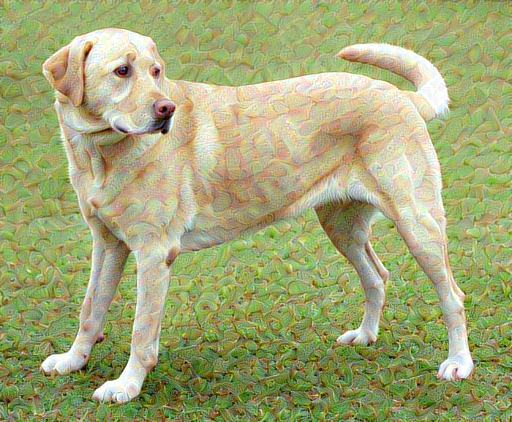

In [ ]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

image = tf.Variable(content_image)

def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min = 0.0, clip_value_max = 1.0)

optimizer = tf.keras.optimizers.Adam(learning_rate = 0.02, beta_1 = 0.99, epsilon = 1e-1)

style_weight=1e-2
content_weight=1e4

def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']

    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name])**2)
                           for name in style_outputs.keys()])

    style_loss *= style_weight / num_style_layers


    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])

    content_loss *= content_weight / num_content_layers

    loss = style_loss + content_loss
    return loss

@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  optimizer.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

In [ ]:
import time
start = time.time()

def adjust_image(image, epochs = 10, steps_per_epoch = 100):
  step = 0
  for n in range(epochs):
    for m in range(steps_per_epoch):
      step += 1
      train_step(image)
      print(".", end='', flush=True)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
    print("Train step: {}".format(step))

  end = time.time()
  print("Total time: {:.1f}".format(end-start))

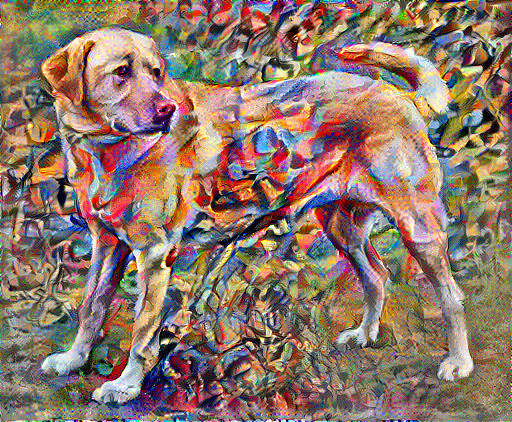

Train step: 2000
Total time: 149.7


In [ ]:
adjust_image(image, 20)

Total variation loss
One downside to this basic implementation is that it produces a lot of high frequency artifacts. Decrease these using an explicit regularization term on the high frequency components of the image. In style transfer, this is often called the total variation loss:

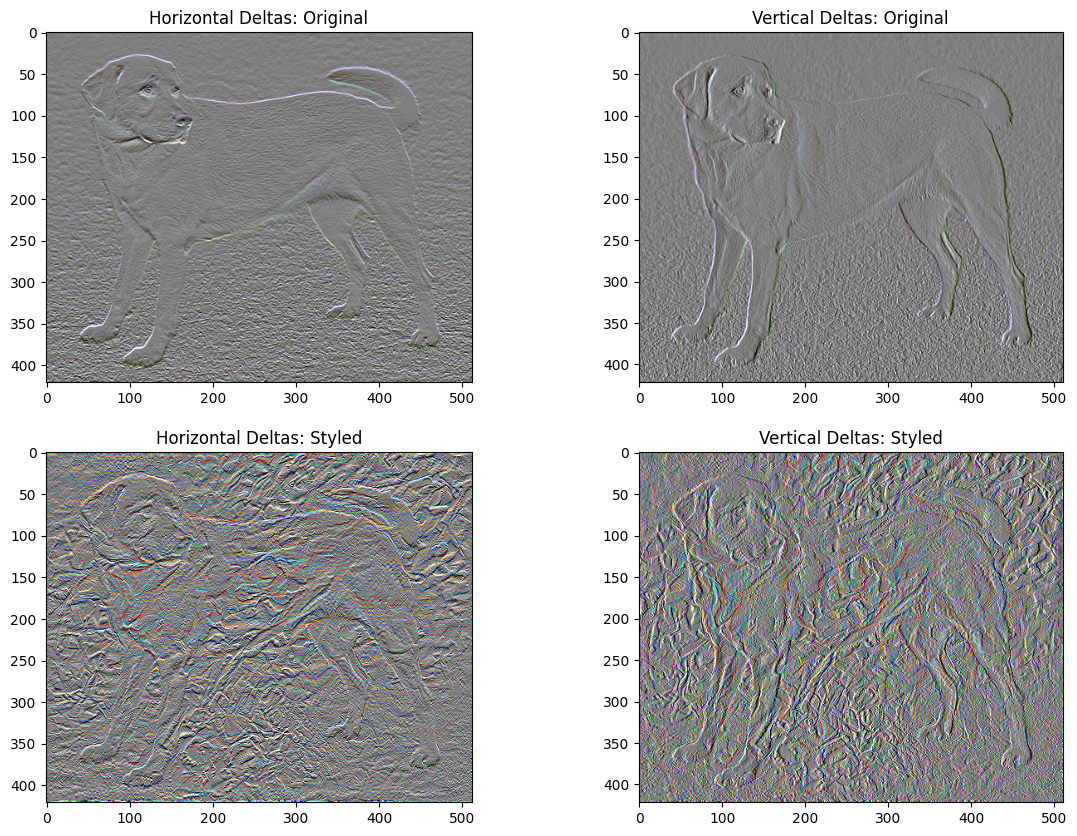

In [ ]:
def high_pass_x_y(image):
  x_var = image[:, :, 1:, :] - image[:, :, :-1, :]
  y_var = image[:, 1:, :, :] - image[:, :-1, :, :]

  return x_var, y_var

x_deltas, y_deltas = high_pass_x_y(content_image)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
show_image(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2, 2, 2)
show_image(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2, 2, 3)
show_image(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2, 2, 4)
show_image(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Styled")

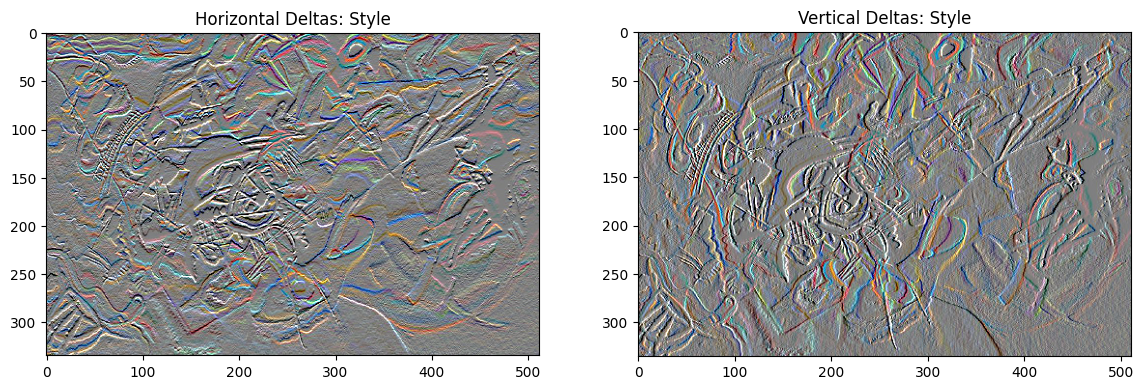

In [ ]:
x_deltas, y_deltas = high_pass_x_y(style_image)

plt.figure(figsize=(14, 10))
plt.subplot(2, 2, 1)
show_image(clip_0_1(2*y_deltas+0.5), "Horizontal Deltas: Style")

plt.subplot(2, 2, 2)
show_image(clip_0_1(2*x_deltas+0.5), "Vertical Deltas: Style")

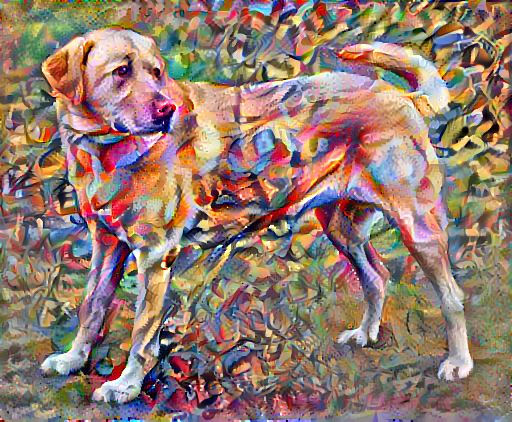

Train step: 1000
Total time: 78.5


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

total_variation_loss(image).numpy()

tf.image.total_variation(image).numpy()

total_variation_weight=30

@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))


opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
image = tf.Variable(content_image)

import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))


file_name = 'stylized-image.png'
tensor_to_image(image).save(file_name)

try:
  from google.colab import files
  files.download(file_name)
except (ImportError, AttributeError):
  pass

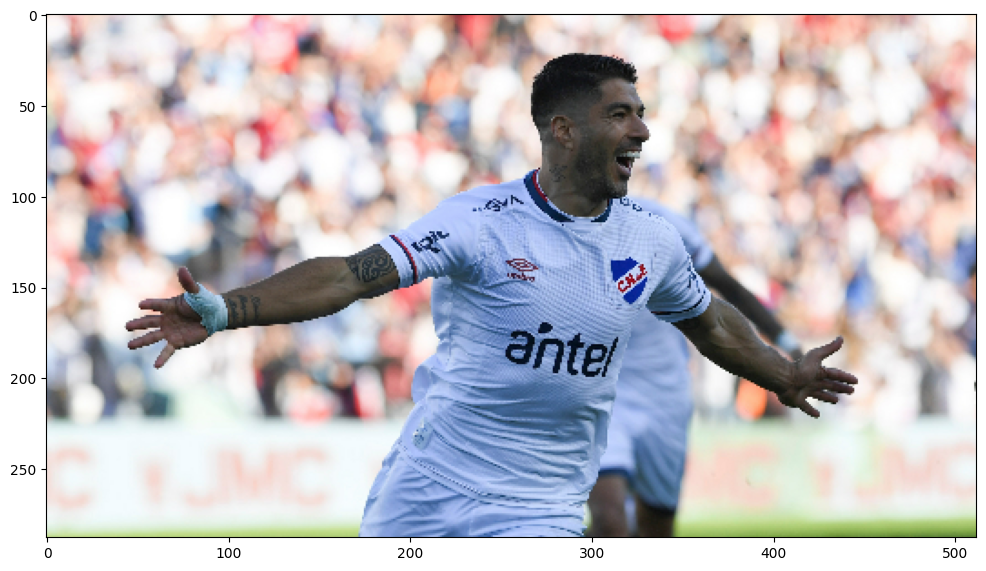

In [ ]:
content_path = 'luis suarez.jpg'

content_image = load_image(content_path)
show_image(content_image)

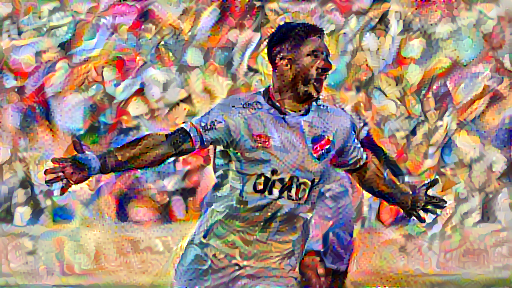

Train step: 1000
Total time: 57.2


In [ ]:
extractor = StyleContentModel(style_layers, content_layers)
result = extractor(tf.constant(content_image))

style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
image = tf.Variable(content_image)

# Redefine train_step to ensure tf.function re-traces it with the new opt and image
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

import time
start = time.time()

epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))